In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

## Movielens 100k

In [0]:
user,item,title = 'userId','movieId','title'

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip -P data/

In [0]:
# !unzip -q data/ml-100k.zip -d data/

In [0]:
path=Path('data/ml-100k/')

In [6]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
len(ratings)

100000

In [8]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title, rating_name='rating')

In [10]:
data.show_batch()

userId,title,target
293,My Family (1995),4.0
405,"Room with a View, A (1986)",2.0
634,Bound (1996),4.0
592,Blade Runner (1982),4.0
118,William Shakespeare's Romeo and Juliet (1996),4.0
533,Apollo 13 (1995),4.0
301,"Boot, Das (1981)",3.0
303,"Saint, The (1997)",2.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


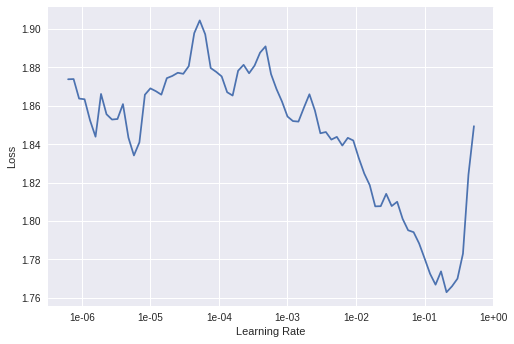

In [13]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [14]:
learn.fit_one_cycle(5, 8e-3)

Total time: 01:02
epoch  train_loss  valid_loss
1      0.906341    0.937574    (00:12)
2      0.899178    0.896472    (00:12)
3      0.779629    0.839263    (00:12)
4      0.611958    0.819811    (00:12)
5      0.481566    0.819765    (00:12)



In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

### Setup

In [0]:
learn.load('dotprod');

In [17]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

`nn.Embedding`:

A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices.

The input to the module is a list of indices, and the output is the corresponding word embeddings.
    
Args:    
- num_embeddings (int): size of the dictionary of embeddings
- embedding_dim (int): the size of each embedding vector

In [18]:
test_embedding = nn.Embedding(10, 3)
test_input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
print(test_input.size())
print(test_embedding.weight.size())

test_embedded = test_embedding(test_input)

print(test_embedded)
print(test_embedded.size())

torch.Size([2, 4])
torch.Size([10, 3])
tensor([[[-0.1775, -0.4711,  1.1461],
         [-0.0245,  0.2616,  1.4554],
         [-1.0509,  0.3310,  0.1879],
         [-0.6590, -1.8675, -0.8843]],

        [[-1.0509,  0.3310,  0.1879],
         [-0.0794, -0.2696,  0.5856],
         [-0.0245,  0.2616,  1.4554],
         [ 0.1082, -1.1483,  0.5470]]], grad_fn=<EmbeddingBackward>)
torch.Size([2, 4, 3])


fastai's class:

```python
class EmbeddingDotBias(nn.Module):
    "Base model for callaborative filtering."
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]
```

Definition of embedding in fastai
```python
def embedding(ni:int,nf:int) -> nn.Module:
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb
```

In [0]:
class DemoEmbeddingDotBias(nn.Module):
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None, verbose:bool=False):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]
        self.verbose = verbose
        if self.verbose:
          print(f'self.u_weight size --> {self.u_weight.weight.size()}')
          print(f'self.i_weight size --> {self.i_weight.weight.size()}')
          print(f'self.u_bias size --> {self.u_bias.weight.size()}')
          print(f'self.i_bias size --> {self.i_bias.weight.size()}')

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.verbose:
          print(f'dot size --> {dot.size()}')
          print(f'res size --> {res.size()}')
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

In [25]:
demo_em = DemoEmbeddingDotBias(10,100,200, verbose=True)

self.u_weight size --> torch.Size([100, 10])
self.i_weight size --> torch.Size([200, 10])
self.u_bias size --> torch.Size([100, 1])
self.i_bias size --> torch.Size([200, 1])


In [20]:
one = next(iter(data.train_dl))
print(one[0][0].size())
print(one[0][1].size())
print(one[1][0].size())

torch.Size([64])
torch.Size([64])
torch.Size([])


In [26]:
test_users = torch.LongTensor([1,2,3,4,5])
test_movies = torch.LongTensor([11,12,13,14,15])
print(test_users.size())
print(test_movies.size())

torch.Size([5])
torch.Size([5])


In [135]:
print(demo_em.u_weight(test_users).size())
print(demo_em.i_weight(test_movies).size())
print(demo_em.u_bias(test_users).size())
print(demo_em.i_bias(test_movies).size())

torch.Size([5, 10])
torch.Size([5, 10])
torch.Size([5, 1])
torch.Size([5, 1])


In [28]:
demo_dot = demo_em.u_weight(test_users)*demo_em.i_weight(test_movies)
print(demo_dot.size())

print(demo_dot.sum(1).size())
print(demo_em.u_bias(test_users).squeeze().size())
print(demo_em.i_bias(test_movies).squeeze().size())

torch.Size([5, 10])
torch.Size([5])
torch.Size([5])
torch.Size([5])


In [137]:
y_test = demo_em(test_users, test_movies)
y_test

dot size --> torch.Size([5, 10])
res size --> torch.Size([5])


tensor([ 0.0036, -0.0006,  0.0082,  0.0041, -0.0124], grad_fn=<AddBackward0>)

In [138]:
demo_em2 = DemoEmbeddingDotBias(10,100,200, y_range=[0,5])
y_test2 = demo_em2(test_users, test_movies)
y_test2

tensor([2.4901, 2.4925, 2.5103, 2.4836, 2.4959], grad_fn=<AddBackward0>)

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [29]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [0]:
learn.bias??

In [31]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [33]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
mean_ratings.head()

title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64

In [0]:
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [36]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4101),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3951),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3380), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3347), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.3279), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.3248), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3023), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3007), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2830), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2775), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2772), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2753), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2662), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2558), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2557), 'Vegas Vacation (1997)',

In [37]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.7529), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6898), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.6522), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6426), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.6318), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.6093), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5982), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5934), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5925), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5717), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.5688), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5592), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5578), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5528), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.5464), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [38]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [39]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [41]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2758), 'Home Alone 3 (1997)'),
 (tensor(1.1636), 'Jungle2Jungle (1997)'),
 (tensor(1.1241), 'Leave It to Beaver (1997)'),
 (tensor(1.0752), 'Congo (1995)'),
 (tensor(1.0665), "McHale's Navy (1997)"),
 (tensor(0.9845), 'D3: The Mighty Ducks (1996)'),
 (tensor(0.9571), 'Shadow Conspiracy (1997)'),
 (tensor(0.9473), 'Bio-Dome (1996)'),
 (tensor(0.9364), 'Batman & Robin (1997)'),
 (tensor(0.9206), 'Speed 2: Cruise Control (1997)')]

In [42]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0252), 'Chinatown (1974)'),
 (tensor(-0.9837),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9713), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9531), 'Close Shave, A (1995)'),
 (tensor(-0.9441), 'Third Man, The (1949)'),
 (tensor(-0.9366), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9273), 'Big Sleep, The (1946)'),
 (tensor(-0.9255), 'Shall We Dance? (1996)'),
 (tensor(-0.9046), 'Lone Star (1996)'),
 (tensor(-0.9037), 'Casablanca (1942)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2208), 'Braveheart (1995)'),
 (tensor(1.1164), 'Titanic (1997)'),
 (tensor(0.9938), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9344), 'Forrest Gump (1994)'),
 (tensor(0.8467), 'Field of Dreams (1989)'),
 (tensor(0.8422), 'Pretty Woman (1990)'),
 (tensor(0.8401), 'Fugitive, The (1993)'),
 (tensor(0.8313), "It's a Wonderful Life (1946)"),
 (tensor(0.8301), "Mr. Holland's Opus (1995)"),
 (tensor(0.8157), 'Back to the Future (1985)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8499), 'Keys to Tulsa (1997)'),
 (tensor(-0.7998), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7648), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7646), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7513), 'Dead Man (1995)'),
 (tensor(-0.7203), 'Stupids, The (1996)'),
 (tensor(-0.7171), 'Brazil (1985)'),
 (tensor(-0.6994), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.6967), 'Heavenly Creatures (1994)'),
 (tensor(-0.6937), 'Very Brady Sequel, A (1996)')]

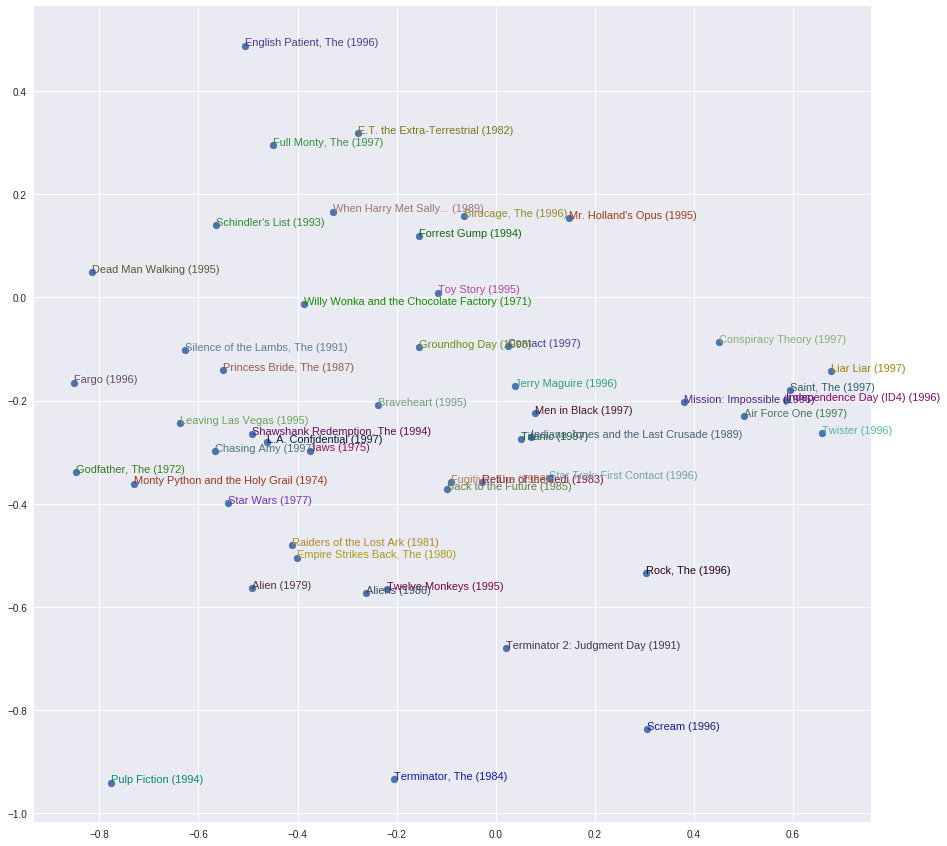

In [46]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()